<a href="https://colab.research.google.com/github/2003UJAN/MARS-Terrain-Aware-Autonomous-Driving/blob/main/MARS_Terrain_Aware_Autonomous_Driving.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'ai4mars-terrainaware-autonomous-driving-on-mars:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F2680112%2F4601270%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240420%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240420T213818Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D942131a360f4490a240806f3f9b2dee93875252ea0e159d256cfa727b0fce23d52aa282f727928d7aef393cf8eae43d01a8f8662b0ddb1016a359c8bad286c47b7aefb932355694f8465565fd3cd2aa884ac9459795b82a51e77fc22e1c8f56e13239656f9c2776f585a8e7b8a0f8651a21196328f37909443cc651040cae66f0d0c62871d56d51dd43fbe7579a7b686c092a4f9f21453b04f0506ef387b7d5863a3d7b500f2ffe73809e15a7ce3085b94e669b7f866674b3333a2cd27d620513e8384c682ddb9f37ff324fb7920da1cd72b887e17ca440bb211f7f70779acff2958edb19b62f8d14f9f859e50f4ef8729988cd245296093d1174f00329e7efe,mars-models:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F3014142%2F5196304%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240420%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240420T213818Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Da49ff29e00af6ef30a74f9f2e5373247dbd006fe2bc58441455348c559e403f775f63eed3bce9e4bda15163264de58bca733626bb361c019fce25ad393fbd1b9522153244dd53de42a848a59d8e09d3a5bc6eb8ec13239353e6fb5062b63fd7c49eda05f72666d5a5e2daf5ab1f06a06af7ec7dff6476fe308dc0157d163a242d0135a154713068903c7fe5a9c55d1e350341a423a7b0d3cdafc35801dcf96ba951b09c6e7fce0f95a9cbe8f2820909f7235017c3f50f3c782e2047005f787cdd2f3b71220fa8b28928f08791ef2265dcf7e5377b824d1ae02d3136a56aec78c2c98412a38f2e8bddb5669b23baf69203cfb8bbe925016e6e92d3d2c226da2f1,synthetic-moon-models:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F3015275%2F5196493%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240420%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240420T213818Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D072b944e58b7099b791a77fc4dfce7cb15120f2b4b5586741ab80218d09bc8b3c17f761eb4e7a6a440f7de30b52420d451f1916acb5211626cc9ec9bae74d04f6fe0dbef9b5d1a49f67e6fc0403c8d933af31ad4e01a4b30a4f386ac6a9bd33baf574998fef3d7013c8ceee1488c31b40a013d80a87929081881f4f3c5b73325b22c1e95b34ea4f41ab457bd3aadb80c39e24dd6aedde79fde3d5fa6341ec13ff049503448dcfc40cd53b1589a063b6588a21472133d045aebdd21dfd2482e3c2e0c26b0ffc796d590da4cfaaf8ba0f07946aafec40b8f73ba715398571814f4ae9248297a3e4825ebe867328d230bb1157d518a81b4de4d88c95e8b07e0fdac'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 6145835638 bytes downloaded
Downloaded and uncompressed: ai4mars-terrainaware-autonomous-driving-on-mars
[==================================================] 556731065 bytes downloaded
Downloaded and uncompressed: mars-models
[==================================================] 658565478 bytes downloaded
Downloaded and uncompressed: synthetic-moon-models
Data source import complete.


# Real Mars Dataset

# Import Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
import torchvision
import torch.nn.functional as F
from torch.autograd import Variable
from torch.nn.parameter import Parameter

from PIL import Image
import cv2
import albumentations as A

import time, math
import os
from tqdm.notebook import tqdm

!pip install -q segmentation-models-pytorch
!pip install -q torchsummary

from torchsummary import summary
import segmentation_models_pytorch as smp

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Training on Device: ", device)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 6.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 12.6 MB/s eta 0:00:00
Training on Device:  cuda


In [ ]:
import random
random_seed = 42
torch.manual_seed(random_seed)
print(device)
if (device != "cpu"):
    torch.cuda.manual_seed(random_seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
random.seed(random_seed)
np.random.seed(random_seed) #if you use numpy

cuda


# Preprocessing

In [ ]:
# synthetic moon image:
# input image --> render
# output image --> ground

IMAGE_PATH = "/kaggle/input/ai4mars-terrainaware-autonomous-driving-on-mars/ai4mars-dataset-merged-0.1/msl/images/edr/"
MASK_PATH_TRAIN = "/kaggle/input/ai4mars-terrainaware-autonomous-driving-on-mars/ai4mars-dataset-merged-0.1/msl/labels/train/"
MASK_PATH_TEST = "/kaggle/input/ai4mars-terrainaware-autonomous-driving-on-mars/ai4mars-dataset-merged-0.1/msl/labels/test/masked-gold-min3-100agree/"

MASK_ROVER = "/kaggle/input/ai4mars-terrainaware-autonomous-driving-on-mars/ai4mars-dataset-merged-0.1/msl/images/mxy/"
RANGE_30M = "/kaggle/input/ai4mars-terrainaware-autonomous-driving-on-mars/ai4mars-dataset-merged-0.1/msl/images/rng-30m/"

black_white = True #transforms it into grayscale
if (black_white): color_channels = 1
else: color_channels = 3

# Generating Dataframe

In [ ]:
def create_df(path):
    name = []
    for dirname, _, filenames in os.walk(path):
        for filename in filenames:

            imname = filename.split('.')[0]
            imname = imname.replace("_merged","")

            #eliminating all images with rover
            rover_raw = np.array(cv2.imread(MASK_ROVER + imname.replace("EDR","MXY") + ".png"))
            rover = np.zeros((1024,1024))
            rover[:,:] = rover_raw[:,:,0]
            if ((rover == 1).any()): continue
            if (imname == "NLB_432655207EDR_F0160148NCAM00394M1"): continue #no correspondence with rng and mxy masks

            name.append(imname)

    return pd.DataFrame({'id': name}, index = np.arange(0, len(name)))

def create_df_sorted(path):
    name = []
    for filename in sorted(os.listdir(path)):

        imname = filename.split('.')[0]
        imname = imname.replace("_merged","")

        #eliminating all images with rover
        rover_raw = np.array(cv2.imread(MASK_ROVER + imname.replace("EDR","MXY") + ".png"))
        rover = np.zeros((1024,1024))
        rover[:,:] = rover_raw[:,:,0]
        if ((rover == 1).any()): continue
        if (imname == "NLB_432655207EDR_F0160148NCAM00394M1"): continue #no correspondence with rng and mxy masks

        name.append(imname)

    return pd.DataFrame({'id': name}, index = np.arange(0, len(name)))

if (not os.path.isfile("/kaggle/input/mars-models/df_train.csv")):
    df_train = create_df(MASK_PATH_TRAIN)
    df_train.to_csv("/kaggle/working/df_train.csv")
else: df_train = pd.read_csv("/kaggle/input/mars-models/df_train.csv")

if (not os.path.isfile("/kaggle/input/mars-models/df_test.csv")):
    df_test = create_df(MASK_PATH_TEST)
    df_test.to_csv("/kaggle/working/df_test.csv")
else: df_test = pd.read_csv("/kaggle/input/mars-models/df_test.csv")

n_train = len(df_train)
n_test = len(df_test)

print('Total Images Train: ', len(df_train))
print('Total Images Test: ', len(df_test))
print(df_test['id'][0])

Total Images Train:  4221
Total Images Test:  80
NLB_500661727EDR_F0503076NCAM07753M1


# Merging Class Labels

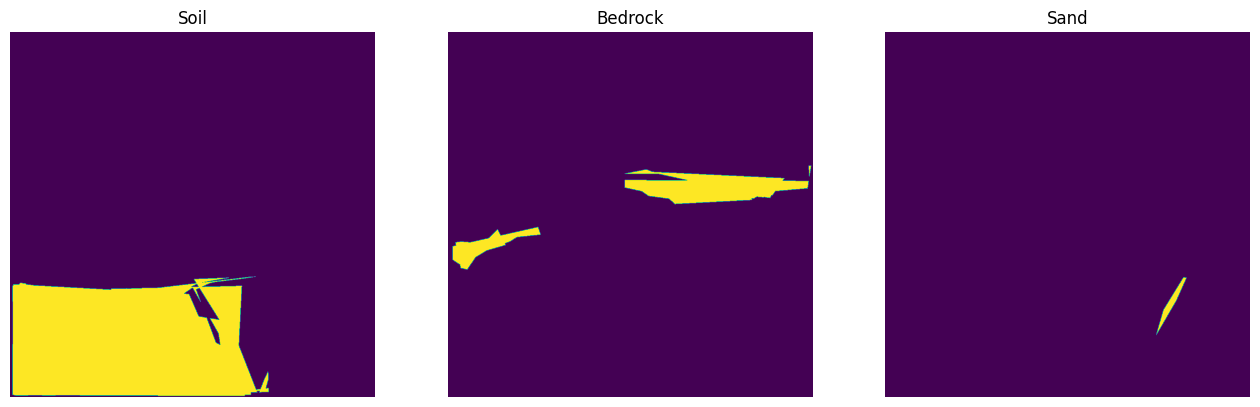

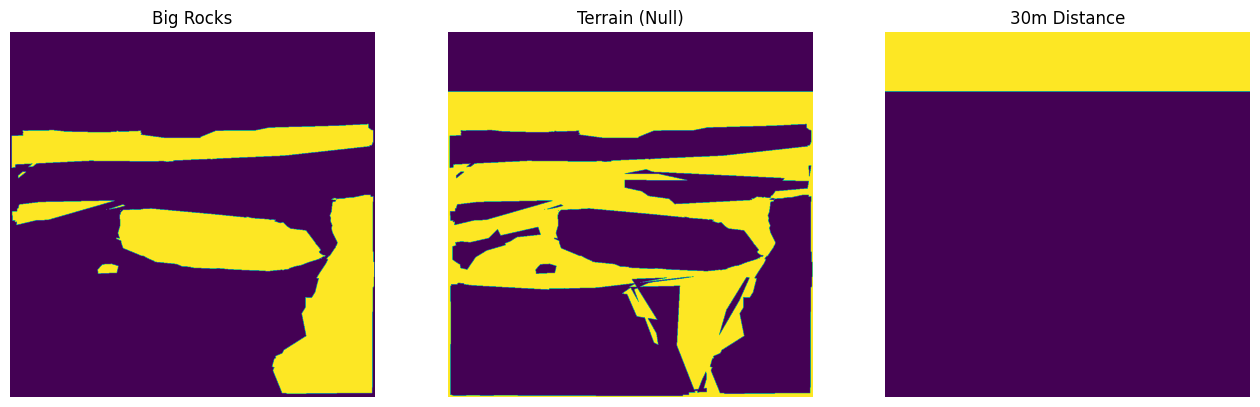

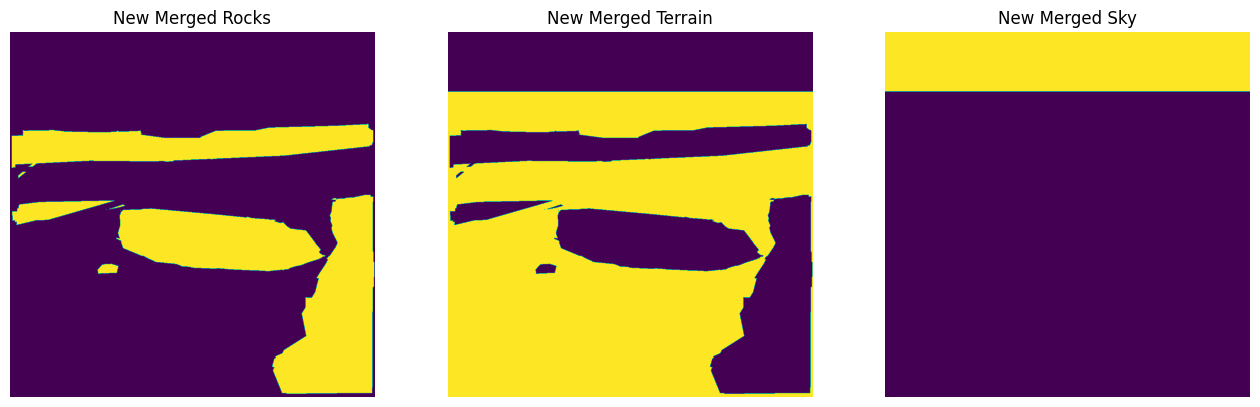

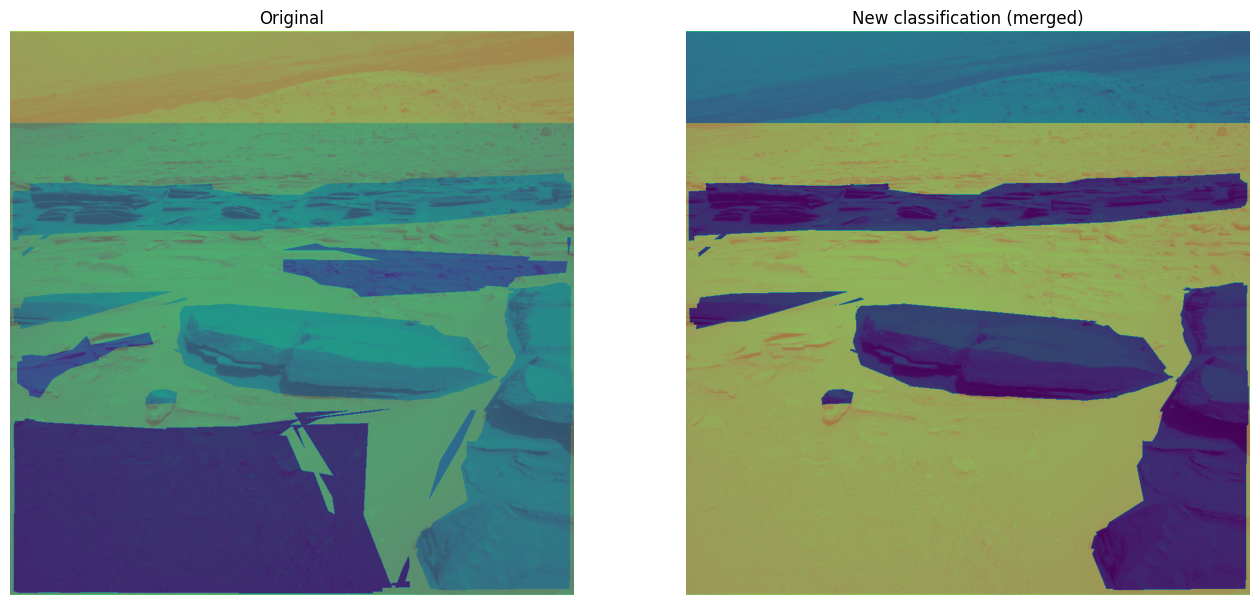

In [ ]:
#0: soil
#1: bedrock
#2: sand
#3: bigrock
#255: NULL

#0,1,2 e NULL (fuori maschera di 30 m) -> Classe 2 (Terreno)
#3 -> Classe 0 (Roccia)
#Maschera 30 m -> Classe 1 (Cielo/Lontano)

#test funzione merge

count = 0
for ix,x in enumerate(df_train['id'].values):

    if (ix < 39): continue

    #ground_truth_raw = np.array(cv2.imread(MASK_PATH_TEST + x + "_merged.png"))
    ground_truth_raw = np.array(cv2.imread(MASK_PATH_TRAIN + x + ".png"))
    img_raw = np.array(cv2.imread(IMAGE_PATH + x + ".JPG"))
    ground_truth = np.zeros((1024,1024))
    img = np.zeros((1024,1024))
    ground_truth[:,:] = ground_truth_raw[:,:,0]
    img[:,:] = img_raw[:,:,0]

    range_30m_raw = np.array(cv2.imread(RANGE_30M + x.replace("EDR","RNG") + ".png"))
    range_30m = np.zeros((1024,1024))
    range_30m[:,:] = range_30m_raw[:,:,0]

    #adding null and sky
    ground_truth[ground_truth == 255] = 4
    ground_truth[range_30m == 1] = 5

    #all components
    ground_truth_0 = np.where(ground_truth == 0, 1, 0)
    ground_truth_1 = np.where(ground_truth == 1, 1, 0)
    ground_truth_2 = np.where(ground_truth == 2, 1, 0)
    ground_truth_3 = np.where(ground_truth == 3, 1, 0)
    ground_truth_4 = np.where(ground_truth == 4, 1, 0)
    ground_truth_5 = np.where(range_30m == 1, 1, 0)

    ground_truth_rocks = ground_truth_3
    ground_truth_terrain = np.logical_or(ground_truth_0,ground_truth_1)
    ground_truth_terrain = np.logical_or(ground_truth_terrain,ground_truth_2)
    ground_truth_terrain = np.logical_or(ground_truth_terrain,ground_truth_4)
    ground_truth_sky = ground_truth_5

    #new mask
    merged_mask = np.zeros((1024,1024))
    merged_mask[ground_truth_rocks == 1] = 0
    merged_mask[ground_truth_sky == 1] = 1
    merged_mask[ground_truth_terrain] = 2

    if ((range_30m == 1).any() and (ground_truth == 0).any()
        and (ground_truth == 1).any() and (ground_truth == 2).any()
        and (ground_truth == 3).any() and (ground_truth == 4).any()):

        # plotting
        fig, ax = plt.subplots(1, 3, figsize=(16,9))
        ax[0].axis('off')
        ax[0].imshow(ground_truth_0)
        ax[0].set_title('Soil')
        ax[1].axis('off')
        ax[1].imshow(ground_truth_1)
        ax[1].set_title('Bedrock')
        ax[2].axis('off')
        ax[2].imshow(ground_truth_2)
        ax[2].set_title('Sand')

        fig, ax = plt.subplots(1, 3, figsize=(16,9))
        ax[0].axis('off')
        ax[0].imshow(ground_truth_3)
        ax[0].set_title('Big Rocks')
        ax[1].axis('off')
        ax[1].imshow(ground_truth_4)
        ax[1].set_title('Terrain (Null)')
        ax[2].axis('off')
        ax[2].imshow(ground_truth_5)
        ax[2].set_title('30m Distance')

        # plotting
        fig, ax = plt.subplots(1, 3, figsize=(16,9))
        ax[0].axis('off')
        ax[0].imshow(ground_truth_rocks)
        ax[0].set_title('New Merged Rocks')
        ax[1].axis('off')
        ax[1].imshow(ground_truth_terrain)
        ax[1].set_title('New Merged Terrain')
        ax[2].axis('off')
        ax[2].imshow(ground_truth_sky)
        ax[2].set_title('New Merged Sky')

        # plotting:
        fig, ax = plt.subplots(1, 2, figsize=(16,9))

        ax[0].axis('off')
        ax[0].imshow(img)
        ax[0].imshow(ground_truth, alpha = 0.5)
        ax[0].set_title('Original')
        ax[1].axis('off')
        ax[1].imshow(img)
        ax[1].imshow(merged_mask, alpha = 0.5)
        ax[1].set_title('New classification (merged)')

        count = count + 1

        if (count == 1): break

# Train-Val-Test Split

In [ ]:
#split data
X_trainval = df_train['id'].values
X_test = df_test['id'].values
X_train, X_val = train_test_split(X_trainval, test_size=0.20, random_state=42)

print('Train Size   : ', len(X_train))
print('Val Size     : ', len(X_val))
print('Test Size    : ', len(X_test))

Train Size   :  3376
Val Size     :  845
Test Size    :  80


In [ ]:
class RealMarsDataset(Dataset):

    def __init__(self, img_path, mask_path, rng_path, X, mean, std, transform=None, patch=False):
        self.img_path = img_path
        self.mask_path = mask_path
        self.range_path = rng_path
        self.X = X
        self.transform = transform
        self.patches = patch
        self.mean = mean
        self.std = std

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):

        #lettura immagini
        img = cv2.imread(self.img_path + self.X[idx] + '.JPG')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) #from BGR to RGB
        mask = cv2.imread(self.mask_path + self.X[idx] + '.png')
        rng30 = cv2.imread(self.range_path + (self.X[idx]).replace("EDR","RNG") + '.png')

        #merging mask
        mask = self.merge_real_mars(mask,rng30)

        #transformations
        if self.transform is not None:
            aug = self.transform(image=img, mask=mask)
            img = Image.fromarray(aug['image'])
            mask = aug['mask']

        if self.transform is None: img = Image.fromarray(img)

        #normalization
        if (black_white): t = T.Compose([T.ToTensor(), T.Normalize(self.mean, self.std), T.Grayscale()])
        else: t = T.Compose([T.ToTensor(), T.Normalize(self.mean, self.std)])
        img = t(img)
        mask = torch.from_numpy(mask).long()

        return img, mask

    def merge_real_mars(self,mask,rng):

        ground_truth = np.zeros(mask[:,:,0].shape)
        ground_truth[:,:] = mask[:,:,0]

        range_30m = np.zeros((rng[:,:,0].shape))
        range_30m[:,:] = rng[:,:,0]

        #adding null and sky
        ground_truth[ground_truth == 255] = 4
        ground_truth[range_30m == 1] = 5

        #all components
        ground_truth_0 = np.where(ground_truth == 0, 1, 0)
        ground_truth_1 = np.where(ground_truth == 1, 1, 0)
        ground_truth_2 = np.where(ground_truth == 2, 1, 0)
        ground_truth_3 = np.where(ground_truth == 3, 1, 0)
        ground_truth_4 = np.where(ground_truth == 4, 1, 0)
        ground_truth_5 = np.where(range_30m == 1, 1, 0)

        ground_truth_rocks = ground_truth_3
        ground_truth_terrain = np.logical_or(ground_truth_0,ground_truth_1)
        ground_truth_terrain = np.logical_or(ground_truth_terrain,ground_truth_2)
        ground_truth_terrain = np.logical_or(ground_truth_terrain,ground_truth_4)
        ground_truth_sky = ground_truth_5

        #new mask
        merged_mask = np.zeros((1024,1024))
        merged_mask[ground_truth_rocks == 1] = 0
        merged_mask[ground_truth_sky == 1] = 1
        merged_mask[ground_truth_terrain] = 2

        return merged_mask

# Computing Mean and Standard Deviations

n_train = len(X_train)

#mean computation
X_train_imgs = 0.

#std dev computation
X_train_imgs_sq = 0.

n_tot = n_train*1024*1024

for i_train,x in enumerate(X_train):
    
    img = cv2.imread(IMAGE_PATH + x + '.JPG')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = np.array(img, dtype = np.int64)
    
    X_train_imgs += np.sum(img[:,:,0])
    X_train_imgs_sq += np.sum(np.square(img[:,:,0]))
    
mean = [X_train_imgs/(n_tot),X_train_imgs/(n_tot),X_train_imgs/(n_tot)]

std_dev = [X_train_imgs_sq/(n_tot) - (mean[0]*mean[0]),
           X_train_imgs_sq/(n_tot) - (mean[1]*mean[1]),
           X_train_imgs_sq/(n_tot) - (mean[2]*mean[2])]

std_dev = np.sqrt(std_dev)

mean = np.divide(mean,255).tolist()
std_dev = np.divide(std_dev,255).tolist()
print(mean)
print(std_dev)

# Data Augmentation and Dataloaders

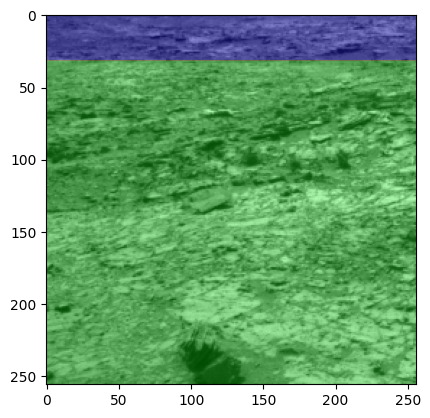

In [ ]:
mean = [0.25362933664907805, 0.25362933664907805, 0.25362933664907805]
std = [0.1054563979418538, 0.1054563979418538, 0.1054563979418538]

npix_x, npix_y = 256,256

t_train = A.Compose([A.HorizontalFlip(p=0.5),
                     A.Blur(p=0.2), #possible dust (very rare)
                     A.RandomScale(scale_limit = (0,0.1), p = 0.5), #possible distortions due to zooming (causing errors in shape...)
                     A.RandomBrightnessContrast(0.5,0.5,p = 0.5), #frequent changes because of illumination
                     A.GaussNoise(10,p=0.3), #interference (rare)
                     A.RandomCrop(512,512,p=0.3), #crop of half the image with same ratio,
                     A.Resize(npix_x,npix_y,always_apply=True,p=1)
                    ])

#no augmentation and mean and std devs are from training as we shouldn't know the distribution of test set in real case scenario
t_val = A.Compose([A.Resize(npix_x,npix_y,always_apply=True,p=1)])
t_test = A.Compose([A.Resize(npix_x,npix_y,always_apply=True,p=1)])

#datasets
train_set = RealMarsDataset(IMAGE_PATH, MASK_PATH_TRAIN, RANGE_30M, X_train, mean, std, t_train)
val_set = RealMarsDataset(IMAGE_PATH, MASK_PATH_TRAIN, RANGE_30M, X_val, mean, std, t_val)
test_set = RealMarsDataset(IMAGE_PATH, MASK_PATH_TRAIN, RANGE_30M, X_val, mean, std, t_test)

test_seg =  train_set[5]
img = test_seg[0].permute(1, 2, 0)
mask = test_seg[1] #.view(480,720)

plt.figure()
plt.imshow(img, cmap = "gray")
plt.imshow(mask,alpha = 0.3, cmap = "brg")

#dataloader
batch_size = 16

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set)

# Class Frequency Distribution

# class frequency
train_count = [0,0,0] #rocks, sky and terrain
val_count = [0,0,0] #rocks, sky and terrain
test_count = [0,0,0] #rocks, sky and terrain

#all pixels
pix_train = 0
pix_val = 0
pix_test = 0

print("\n- TRAIN")
for i_train,x in enumerate(train_set):
    
    if (i_train % (int(len(train_set)/10)) == 0): print("- %i / %i" % (i_train,len(train_set)))
    data = x[1]
    
    pix_train += data.shape[0]*data.shape[1]
    train_count[0] += np.count_nonzero(data == 0)
    train_count[1] += np.count_nonzero(data == 1)
    train_count[2] += np.count_nonzero(data == 2)
    
train_count = np.divide(train_count,pix_train)
print(train_count)

print("\n- TEST")
for i_test,x in enumerate(test_set):
    
    if (i_test % (int(len(test_set)/10)) == 0): print("- %i / %i" % (i_test,len(test_set)))
    data = x[1]
    
    pix_test += data.shape[0]*data.shape[1]
    test_count[0] += np.count_nonzero(data == 0)
    test_count[1] += np.count_nonzero(data == 1)
    test_count[2] += np.count_nonzero(data == 2)

test_count = np.divide(test_count,pix_test)
print(test_count)

print("\n- VALIDATION")
for i_val,x in enumerate(val_set):
    
    if (i_val % (int(len(val_set)/10)) == 0): print("- %i / %i" % (i_val,len(val_set)))
    data = x[1]
    
    pix_val += data.shape[0]*data.shape[1]
    val_count[0] += np.count_nonzero(data == 0)
    val_count[1] += np.count_nonzero(data == 1)
    val_count[2] += np.count_nonzero(data == 2)
    
val_count = np.divide(val_count,pix_val)
print(val_count)

<Figure size 640x480 with 0 Axes>

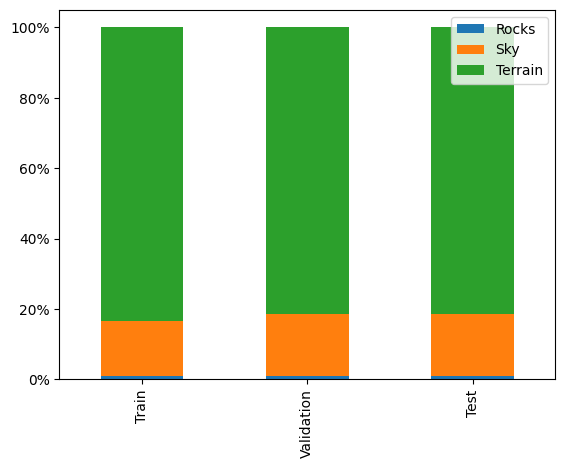

In [ ]:
train_count = [0.00995943, 0.15648488, 0.83355568]
val_count = [0.00825022, 0.17790773, 0.81384205]
test_count = [0.00825022, 0.17790773, 0.81384205]

rocks_count = [train_count[0],val_count[0],test_count[0]]
sky_count = [train_count[1],val_count[1],test_count[1]]
terrain_count = [train_count[2],val_count[2],test_count[2]]

index = ['Train','Validation','Test']
df_frequency = pd.DataFrame({'Rocks': rocks_count, 'Sky': sky_count, 'Terrain': terrain_count},index)

from matplotlib.ticker import PercentFormatter
plt.figure()
df_frequency.plot.bar(stacked = True)
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

# Defining the UNet Segmentation Models

# 1. Defining ResNet encoder using serial and parallel adapters

In [ ]:
def conv3x3(in_planes, out_planes, stride=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False)

def conv1x1_fonc(in_planes, out_planes=None, stride=1, bias=False):
    if out_planes is None:
        return nn.Conv2d(in_planes, in_planes, kernel_size=1, stride=stride, padding=0, bias=bias)
    else:
        return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, padding=0, bias=bias)

class conv1x1(nn.Module):

    def __init__(self, planes, mode, out_planes=None, stride=1):

        super(conv1x1, self).__init__()
        self.mode = mode

        if self.mode == 'series_adapters':
            self.conv = nn.Sequential(nn.BatchNorm2d(planes), conv1x1_fonc(planes))

        elif self.mode == 'parallel_adapters':
            self.conv = conv1x1_fonc(planes, out_planes, stride)

        else:
            self.conv = conv1x1_fonc(planes)

    def forward(self, x):
        y = self.conv(x)
        if self.mode == 'series_adapters':
            y += x
        return y

#adapter module!
class conv_task(nn.Module):

    def __init__(self, in_planes, planes, mode, stride=1, is_proj=1, second=0):
        super(conv_task, self).__init__()
        self.is_proj = is_proj
        self.second = second #every residual skip connection has two conv blocks
        self.conv = conv3x3(in_planes, planes, stride)
        self.mode = mode #series or parallel

        if self.mode == 'series_adapters' and self.is_proj:
            self.bns = nn.Sequential(conv1x1(planes, mode), nn.BatchNorm2d(planes))
        elif self.mode == 'parallel_adapters' and self.is_proj:
            self.parallel_conv = conv1x1(in_planes, mode, planes, stride)
            self.bns = nn.BatchNorm2d(planes)
        else:
            self.bns = nn.BatchNorm2d(planes)

    def forward(self, x):

        y = self.conv(x)

        if self.second == 0: x = F.dropout2d(x, p=0.5, training = self.training)
        else: x = F.dropout2d(x, p=0.5, training = self.training)

        if self.mode == 'parallel_adapters' and self.is_proj: y = y + self.parallel_conv(x)
        y = self.bns(y)

        return y

#changing the basic block of resnet
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, mode, stride=1, downsample = None):
        super(BasicBlock, self).__init__()

        self.mode = mode #series, parallel or none

        self.conv1 = conv_task(in_planes, planes, self.mode, stride, is_proj= 1)
        self.conv2 = nn.Sequential(nn.ReLU(True), conv_task(planes, planes, self.mode, 1, is_proj = 1, second=1))

        self.downsample = downsample

    def forward(self, x):
        residual = x
        y = self.conv1(x)
        y = self.conv2(y)

        if self.downsample is not None:
            residual = self.downsample(x)

        y += residual
        y = F.relu(y)
        return y


class ResNetEncoder_Adapter(nn.Module):

    def __init__(self, block, nblocks, mode, color_channels = 3):
        super(ResNetEncoder_Adapter, self).__init__()

        self.mode = mode
        blocks = [block, block, block, block] #4 main blocks!
        self.in_planes = 64
        self.output_stride = 32 #need it to check input size in model, which requires height and wodth divisible by 32

        self.conv1 = nn.Conv2d(color_channels, 64, kernel_size=7, stride=2, padding=3,bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(blocks[0], 64, nblocks[0], stride=1)
        self.layer2 = self._make_layer(blocks[1], 128, nblocks[1], stride=2)
        self.layer3 = self._make_layer(blocks[2], 256, nblocks[2], stride=2)
        self.layer4 = self._make_layer(blocks[3], 512, nblocks[3], stride=2)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, nblocks, stride = 1):

        downsample = None

        if stride != 1 or self.in_planes != planes * block.expansion:

            downsample = nn.Sequential(
                nn.Conv2d(self.in_planes, planes * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.in_planes, planes, self.mode, stride, downsample))
        self.in_planes = planes * block.expansion
        for i in range(1, nblocks):
            layers.append(block(self.in_planes, planes, self.mode))
        return nn.Sequential(*layers)

    def get_stages(self): #need them for lather with decoder blocks

        return [
            nn.Identity(),
            nn.Sequential(self.conv1, self.bn1, self.relu),
            nn.Sequential(self.maxpool, self.layer1),
            self.layer2,
            self.layer3,
            self.layer4,
        ]

    def forward(self, x):

        stages = self.get_stages()

        features = []
        for i in range(6):
            x = stages[i](x)
            features.append(x)

        return features

# 2. Defining UNet with ResNet encoder with adapters

In [ ]:
from typing import Optional, Union, List
from segmentation_models_pytorch.base import (
    SegmentationModel,
    SegmentationHead,
    ClassificationHead,
)
from segmentation_models_pytorch.decoders.unet.decoder import *

In [ ]:
class Unet_Adapters(SegmentationModel):

    def __init__(
        self,
        encoder_adapt,
        encoder_channels,
        encoder_depth,
        decoder_use_batchnorm: bool = True,
        decoder_channels: List[int] = (256, 128, 64, 32, 16),
        decoder_attention_type: Optional[str] = None,
        in_channels: int = 3,
        classes: int = 1,
        activation: Optional[Union[str, callable]] = None,
        aux_params: Optional[dict] = None,
    ):
        super().__init__()

        self.encoder = encoder_adapt

        self.decoder = UnetDecoder(
            encoder_channels = encoder_channels,
            decoder_channels = decoder_channels,
            n_blocks = encoder_depth,
            use_batchnorm=decoder_use_batchnorm,
            attention_type=decoder_attention_type,
        )

        self.segmentation_head = SegmentationHead(
            in_channels=decoder_channels[-1],
            out_channels=classes,
            activation=activation,
            kernel_size=3,
        )

        if aux_params is not None:
            self.classification_head = ClassificationHead(in_channels=self.encoder.out_channels[-1], **aux_params)
        else:
            self.classification_head = None

        self.name = "u-resnet18-adapt"
        self.initialize()

# 3. Defining the UNet Segmentation Models

In [ ]:
#no adapters...
unet = smp.Unet('resnet18', decoder_channels = (256, 128, 64, 32, 16), classes = 3, activation = None, in_channels = color_channels) #baseline

#unet from smob
unet_smob, history_smob = torch.load("/kaggle/input/synthetic-moon-models/Unet_baseline_smob.pt", map_location=torch.device('cpu'))

#unet with adapters from smob
unet_smob_parall, history_smob_parall = torch.load("/kaggle/input/synthetic-moon-models/Unet_adapt_smob_parall_offshelf.pt")
unet_smob_series, history_smob_series = torch.load("/kaggle/input/synthetic-moon-models/Unet_adapt_smob_series_offshelf.pt")

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 85.0MB/s]


In [ ]:
#choosing which one to train (or finetune)
unet_train = unet_smob_parall

# Metrics

In [ ]:
import sklearn.metrics as metrics
metric_names = ["Accuracy","Balanced Accuracy","Jaccard Score"]

In [ ]:
#modifying balanced accuracy
def balanced_accuracy_score(y_true, y_pred):

    #should use labels = [0,1,2]
    C = metrics.confusion_matrix(y_true, y_pred, labels = [0,1,2])

    with np.errstate(divide="ignore", invalid="ignore"):
        per_class = np.diag(C) / C.sum(axis=1) #tp/(tp+fn)

    for irec,rec in enumerate(per_class):
        #label is not in ground truth and is not predicted
        if (np.isnan(rec) and C.sum(axis=0)[irec] == 0): rec = 1 #no true pos, no true neg and no false positive

    #if there are false positives but no false negative and true positive remains nan
    per_class = per_class[~np.isnan(per_class)]

    score = np.nanmean(per_class)
    return score

In [ ]:
def pixel_metrics(output, mask, metric = "acc"):

    with torch.no_grad():

        #applying softmax and choosing best class with argmax
        output = F.softmax(output, dim=1) #on all colors
        output = torch.argmax(output, dim=1) #on all colors

        #need 1d vectors for sklearn.metrics -> need cpu to convert to numpy
        output = output.cpu().contiguous().view(-1) #1d
        mask = mask.cpu().contiguous().view(-1) #1d

    if (metric == "Accuracy"): return metrics.accuracy_score(mask,output)
    #if (metric == "Balanced Accuracy"): return metrics.balanced_accuracy_score(mask,output)
    if (metric == "Balanced Accuracy"): return balanced_accuracy_score(mask,output)
    if (metric == "Confusion Matrix"): return metrics.confusion_matrix(mask,output,labels = [0,1,2])
    if (metric == "Jaccard Score"): return metrics.jaccard_score(mask,output,average = "macro",zero_division = 1)
    else:
        print("Metric not found...")
        return None

In [ ]:
#recursive function to get every child of model and access to batchnorm layers
def eval_childrens_batchnorm(child, batchnorm = True): #True if batchnorm is in training mode

    subchildrens = child.children()
    n_childrens = len(list(subchildrens))

    #no other subchildren...
    if (n_childrens == 0):

        #batchnorm has running stats = True and requires grad = True
        if (isinstance(child, nn.BatchNorm2d)):

            for par in child.parameters():
                if (batchnorm): par.requires_grad = True
                else:
                    par.track_running_stats = False
                    par.requires_grad = False

        #every other layer is set to evaluation mode
        else:
            #print("Setting to Grad = %i " % (not batchnorm),child)
            for par in child.parameters():
                if (batchnorm): par.requires_grad = False
                else: par.requires_grad = True

    else: #other childrens...

        for subchild in child.children():
            eval_childrens_batchnorm(subchild) #recursive call

In [ ]:
#custom function to freeze encoder, decoder, ... with options for batchnorm and adapters
def custom_model_train(model, enc = True, dec = True, seg = True, batchnorm = True):

    #True if active
    model.train()

    encoder = model.get_submodule("encoder")
    decoder = model.get_submodule("decoder")
    seg_head = model.get_submodule("segmentation_head")

    #encoder
    if (not enc and not batchnorm): #freezing encoder and batchnorm to evaluation mode
        encoder.eval()

    if (not enc and batchnorm): #freezing encoder leaving batchnorm to train

        for child in (encoder.children()):
            eval_childrens_batchnorm(child, batchnorm)

    if (enc and not batchnorm): #training mode but batchnorm to evaluation mode

        for child in (encoder.children()):
            eval_childrens_batchnorm(child, batchnorm)

    #the other case is if encoder and batchnorm are both in training mode (no need to do anything)

    #decoder
    if (not dec and not batchnorm): #freezing decoder and batchnorm to evaluation mode
        decoder.eval()

    if (not dec and batchnorm): #freezing decoder leaving batchnorm to train

        for child in (decoder.children()):
            eval_childrens_batchnorm(child, batchnorm)

    if (dec and not batchnorm): #training mode but batchnorm to evaluation mode

        for child in (decoder.children()):
            eval_childrens_batchnorm(child, batchnorm)

    #the other case is if decoder and batchnorm are both in training mode (no need to do anything)

    #segmentation head
    if (not seg and not batchnorm): #freezing seg head and batchnorm to evaluation mode
        seg_head.eval()

    if (not seg and batchnorm): #freezing seg head leaving batchnorm to train

        for child in (seg_head.children()):
            eval_childrens_batchnorm(child, batchnorm)

    if (seg and not batchnorm): #training mode but batchnorm to evaluation mode

        for child in (seg_head.children()):
            eval_childrens_batchnorm(child, batchnorm)

    #the other case is if seg head and batchnorm are both in training mode (no need to do anything)


In [ ]:
#defining a function to set to evaluation mode everything except batchnorm and adapters!
def eval_childrens_batchnorm_adapter(child, batchnorm, adapters):

    global ichild
    subchildrens = child.children()
    n_childrens = len(list(subchildrens))

    #no other subchildren...
    if (n_childrens == 0):

        if (ichild in adapters):
            #print(ichild,"Setting to Grad = True ",child)
            for par in child.parameters():
                par.requires_grad = True
                if (isinstance(child, nn.BatchNorm2d)): par.track_running_stats = True #batchnorm layers part of adapters

        #batchnorm has running stats = True and requires grad = True
        elif (isinstance(child, nn.BatchNorm2d) and batchnorm):
            #print(ichild,"Setting to Grad = True ",child)
            for par in child.parameters():
                par.requires_grad = True
                par.track_running_stats = True

        else:
            for par in child.parameters():
                par.requires_grad = False
                if (isinstance(child, nn.BatchNorm2d)): par.track_running_stats = False
            #print(ichild,"Setting to Grad = False ",child)

        #global counter
        ichild = ichild + 1

    else: #other childrens...

        for subchild in child.children():
            eval_childrens_batchnorm_adapter(subchild,batchnorm,adapters) #recursive call

In [ ]:
def custom_model_train_adapt(model, batchnorm, adapt): #similar function for adapters

    #batchnorm to True if training
    #adapt to None to switch off adapters, series for series and parallel for parallel

    model.eval()
    if (adapt == "parallel"): par_adapters = [5,9,12,16,19,23,28,32,35,39,44,48,51,55,60,64]
    elif (adapt == "series"): par_adapters = [6, 11, 15, 20, 24, 29, 35, 40, 44, 49, 55, 60, 64, 69, 75, 80, 5, 10, 14, 19, 23, 28, 34, 39, 43, 48, 54, 59, 63, 68, 74, 79]
    else: par_adapters = []

    global ichild
    ichild = 0
    for child in (model.get_submodule("encoder").children()):
        eval_childrens_batchnorm_adapter(child,batchnorm,par_adapters)

    for child in (model.get_submodule("decoder").children()):
        eval_childrens_batchnorm_adapter(child,batchnorm,[])

    for child in (model.get_submodule("segmentation_head").children()):
        eval_childrens_batchnorm_adapter(child,batchnorm,[])

In [ ]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit(epochs, model, train_loader, val_loader, criterion, optimizers, schedulers, stopat = None):

    torch.cuda.empty_cache()

    train_losses = []
    test_losses = []

    train_metrics = []
    test_metrics = []

    lrs = [] #list of all learning rates for each epoch e.g. [[0.001,0.005,0.01],[0.0009,0.004,0.009],...]

    min_loss = np.inf
    decrease = 1
    not_improve = 0

    model.to(device)
    fit_time = time.time()

    for e in range(epochs):

        since = time.time()
        running_loss = 0

        train_metr_epoch = [0,0,0]
        test_metr_epoch = [0,0,0]
        lr_list = [] #learning rate for each optimizer e.g. [0.001,0.005,0.01]

        #training loop
        #model.train()
        #custom_model_train(model, enc = False, dec = False, seg = False, batchnorm = True)
        custom_model_train_adapt(model, batchnorm = False, adapt = "parallel")

        for i, data in enumerate(tqdm(train_loader)):

            if (stopat is not None and i == stopat): break

            #training phase
            image, mask = data

            image = image.to(device)
            mask = mask.to(device)

            #forward
            output = model(image)
            loss = criterion(output, mask)

            #evaluation metrics
            for imetr,metr in enumerate(metric_names):
                train_metr_epoch[imetr] += pixel_metrics(output,mask,metr)

            #backward
            loss.backward()

            for optimizer in optimizers:

                optimizer.step() #update weight
                optimizer.zero_grad() #reset gradient

                #step the learning rate
                if (i==0): lr_list.append(get_lr(optimizer)) #need it only for first element of dataloader

            running_loss += loss.item()

        #end training

        #step the learning rate
        lrs.append(lr_list)

        #scheduler step at each epoch
        for scheduler in schedulers:
            if (scheduler is not None): scheduler.step()

        #start evaluation
        model.eval()
        test_loss = 0.

        #validation loop
        with torch.no_grad():

            for i, data in enumerate(tqdm(val_loader)):

                if (stopat is not None and i == stopat): break

                image, mask = data
                image = image.to(device)
                mask = mask.to(device)

                #forward
                output = model(image)
                loss = criterion(output, mask)

                #evaluation metrics
                for imetr,metr in enumerate(metric_names):
                    test_metr_epoch[imetr] += pixel_metrics(output,mask,metr)

                test_loss += loss.item()

        #calculatio mean for each batch
        train_losses.append(running_loss/len(train_loader))
        test_losses.append(test_loss/len(val_loader))

        train_metrics.append(np.divide(train_metr_epoch,len(train_loader)).tolist())
        test_metrics.append(np.divide(test_metr_epoch,len(val_loader)).tolist())

        if min_loss > (test_loss/len(val_loader)):

            print('Loss Decreasing for {:}-th Time {:.3f} >> {:.3f} '.format(decrease, min_loss, (test_loss/len(val_loader))))
            min_loss = (test_loss/len(val_loader))
            decrease += 1

            #saving every 5 decrease
            #if decrease % 5 == 0:
            #    print('Saving model...')
            #    torch.save(model, 'Unet-{decrease}.pt')

        if (test_loss/len(val_loader)) > min_loss:

            not_improve += 1
            min_loss = (test_loss/len(val_loader))
            print('Loss Not Decreasing for {}-th Time'.format(not_improve))

        print("Epoch:{}/{}..".format(e+1, epochs),
              "Train Loss: {:.3f}..".format(running_loss/len(train_loader)),
              "Val Loss: {:.3f}..".format(test_loss/len(val_loader)))

        for imetr,metr in enumerate(metric_names):
            print("Train " + metr + ": {:.3f}".format(train_metrics[e][imetr]))
            print("Val " + metr + ": {:.3f}".format(test_metrics[e][imetr]))

    history = {'train_loss' : train_losses, 'val_loss': test_losses,
               'train_metric' : train_metrics, 'val_metric': test_metrics,
               'lrs': lrs}

    print('Total time: {:.2f} m' .format((time.time()- fit_time)/60))
    return history

# Training Baseline U-Net

!pip install -q torch_lr_finder
from torch_lr_finder import LRFinder

last_lr_enc = history_smob['lrs'][-1][0]
last_lr_dec = history_smob['lrs'][-1][1]
last_lr_seg = history_smob['lrs'][-1][2]

weight_decay = 1e-4
criterion = nn.CrossEntropyLoss()
optimizer_encoder = torch.optim.AdamW(unet.get_submodule("encoder").parameters(), lr=0.001, weight_decay=weight_decay)
optimizer_decoder = torch.optim.AdamW(unet.get_submodule("decoder").parameters(), lr=0.001, weight_decay=weight_decay)
optimizer_seghead = torch.optim.AdamW(unet.get_submodule("segmentation_head").parameters(), lr=0.001, weight_decay=weight_decay)

lr_finder_enc = LRFinder(unet_smob, optimizer_encoder, criterion, device="cuda")
lr_finder_enc.range_test(train_loader, start_lr = 1e-6, end_lr = 1e-1, num_iter=100)
lr_finder_enc.plot() # to inspect the loss-learning rate graph
lr_finder_enc.reset() # to reset the model and optimizer to their initial state

lr_finder_dec = LRFinder(unet_smob, optimizer_decoder, criterion, device="cuda")
lr_finder_dec.range_test(train_loader, start_lr = 1e-6, end_lr = 1e-1, num_iter=100)
lr_finder_dec.plot() # to inspect the loss-learning rate graph
lr_finder_dec.reset() # to reset the model and optimizer to their initial state

lr_finder_seg = LRFinder(unet_smob, optimizer_seghead, criterion, device="cuda")
lr_finder_seg.range_test(train_loader, start_lr = 1e-6, end_lr = 1e-1, num_iter=100)
lr_finder_seg.plot() # to inspect the loss-learning rate graph
lr_finder_seg.reset() # to reset the model and optimizer to their initial state

In [ ]:
max_lr = 0.001 #learning rate of encoder in unet baseline
epoch = 5
weight_decay = 1e-4

criterion = nn.CrossEntropyLoss()
optimizer_encoder = torch.optim.AdamW(unet_train.get_submodule("encoder").parameters(), lr=max_lr/5, weight_decay=weight_decay)
optimizer_decoder = torch.optim.AdamW(unet_train.get_submodule("decoder").parameters(), lr=max_lr, weight_decay=weight_decay)
optimizer_seghead = torch.optim.AdamW(unet_train.get_submodule("segmentation_head").parameters(), lr=max_lr, weight_decay=weight_decay)
optimizer = [optimizer_encoder,optimizer_decoder,optimizer_seghead]

'''
#optimizer = torch.optim.AdamW(model.parameters(), lr=max_lr, weight_decay=weight_decay)
sched_encoder = torch.optim.lr_scheduler.ExponentialLR(optimizer_encoder, gamma = 0.93) #0.1 factor every 30 epochs
sched_decoder = torch.optim.lr_scheduler.ExponentialLR(optimizer_decoder, gamma = 0.93)
sched_seghead = torch.optim.lr_scheduler.ExponentialLR(optimizer_seghead, gamma = 0.93)
sched = [sched_encoder,sched_decoder,sched_seghead]
'''
'''
sched_encoder = None
sched_decoder = None
sched_seghead = None
sched = [sched_encoder,sched_decoder,sched_seghead]
'''

sched_encoder = torch.optim.lr_scheduler.StepLR(optimizer_encoder, step_size = 3, gamma = 0.79)
sched_decoder = torch.optim.lr_scheduler.StepLR(optimizer_decoder, step_size = 3, gamma = 0.79)
sched_seghead = torch.optim.lr_scheduler.StepLR(optimizer_seghead, step_size = 3, gamma = 0.79)
sched = [sched_encoder,sched_decoder,sched_seghead]

history = fit(epoch, unet_train, train_loader, val_loader, criterion, optimizer, sched)

  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

Loss Decreasing for 1-th Time inf >> 0.201 
Epoch:1/5.. Train Loss: 0.290.. Val Loss: 0.201..
Train Accuracy: 0.895
Val Accuracy: 0.926
Train Balanced Accuracy: 0.540
Val Balanced Accuracy: 0.590
Train Jaccard Score: 0.469
Val Jaccard Score: 0.533


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

Loss Decreasing for 2-th Time 0.201 >> 0.194 
Epoch:2/5.. Train Loss: 0.239.. Val Loss: 0.194..
Train Accuracy: 0.912
Val Accuracy: 0.921
Train Balanced Accuracy: 0.554
Val Balanced Accuracy: 0.568
Train Jaccard Score: 0.493
Val Jaccard Score: 0.516


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

Loss Decreasing for 3-th Time 0.194 >> 0.177 
Epoch:3/5.. Train Loss: 0.213.. Val Loss: 0.177..
Train Accuracy: 0.922
Val Accuracy: 0.931
Train Balanced Accuracy: 0.576
Val Balanced Accuracy: 0.586
Train Jaccard Score: 0.513
Val Jaccard Score: 0.539


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

Loss Not Decreasing for 1-th Time
Epoch:4/5.. Train Loss: 0.208.. Val Loss: 0.187..
Train Accuracy: 0.921
Val Accuracy: 0.930
Train Balanced Accuracy: 0.572
Val Balanced Accuracy: 0.629
Train Jaccard Score: 0.514
Val Jaccard Score: 0.554


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

Loss Decreasing for 4-th Time 0.187 >> 0.181 
Epoch:5/5.. Train Loss: 0.201.. Val Loss: 0.181..
Train Accuracy: 0.925
Val Accuracy: 0.933
Train Balanced Accuracy: 0.582
Val Balanced Accuracy: 0.622
Train Jaccard Score: 0.520
Val Jaccard Score: 0.555
Total time: 49.90 m


In [ ]:
##### nomenclatura Unet_resnet18_0.001_explr.pt
torch.save((unet_train,history),'/kaggle/input/mars-models/Unet_baseline_rmab.pt')

In [ ]:
unet_load,history_load = torch.load('/kaggle/input/mars-models/Unet_finetuning_rmab_full.pt')

In [ ]:
def plot_loss(history):

    plt.figure()
    plt.plot(history['val_loss'], label='Validation Loss', marker='o', color = "blue", linestyle = "dashed")
    plt.plot(history['train_loss'], label='Training Loss', marker='o', color = "green",linestyle = "dashed")
    plt.title('Loss per epoch')
    plt.ylabel('Categorical Cross Entropy Loss');
    plt.xlabel('Epoch')
    plt.legend(loc = "best")
    plt.grid()
    plt.show()

def plot_score(history):

    for imetr,metr in enumerate(metric_names):

        train_score = [history['train_metric'][e][imetr] for e in range(len(history['train_metric']))]
        val_score = [history['val_metric'][e][imetr] for e in range(len(history['val_metric']))]

        plt.figure()
        plt.plot(train_score, label = "Training " + metr, marker='o', color = "green", linestyle = "dashed")
        plt.plot(val_score, label = "Validation " + metr, marker='o', color = "blue",linestyle = "dashed")
        plt.title('Score per epoch')
        plt.ylabel("Mean " + metr)
        plt.xlabel('Epoch')
        plt.legend(loc = "best")
        plt.grid()
        plt.show()

def plot_lrs(history):

    nlrs = len(history['lrs'][0])
    lr_epoch = []
    colors = ["r","g","b","c","m","y"]
    labels = ["Encoder","Decoder","Segmentation Head"]

    for ilr in range(nlrs):
        lr_epoch.append([history['lrs'][e][ilr] for e in range(len(history['lrs']))])

    plt.figure()
    for ilr in range(nlrs):
        plt.plot(lr_epoch[ilr], marker='o', color = colors[ilr], label = labels[ilr], linestyle = "dashed")
    plt.title('Learning Rates per epoch')
    plt.ylabel("Learning Rate")
    plt.xlabel('Epoch')
    #plt.yscale("log")
    plt.legend(loc = "best")
    plt.grid()
    plt.show()

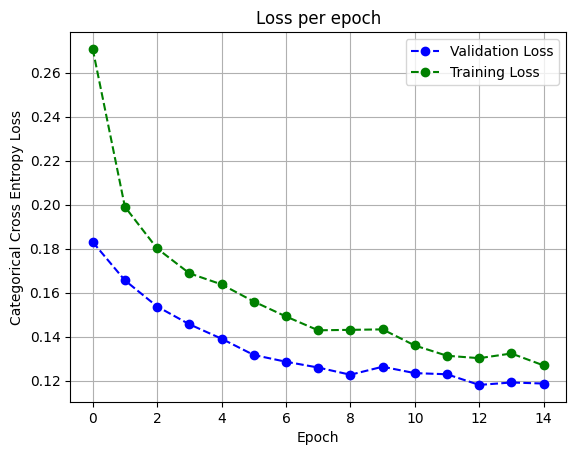

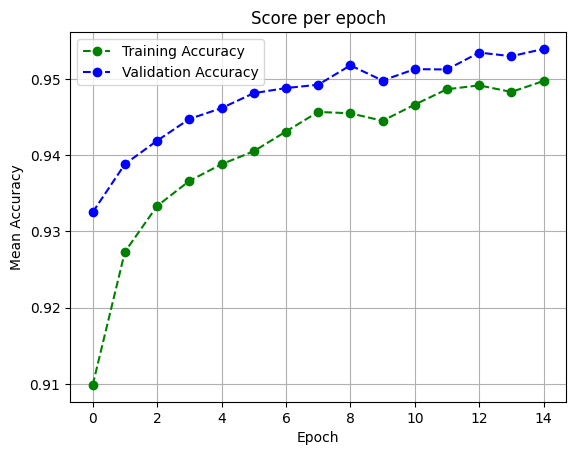

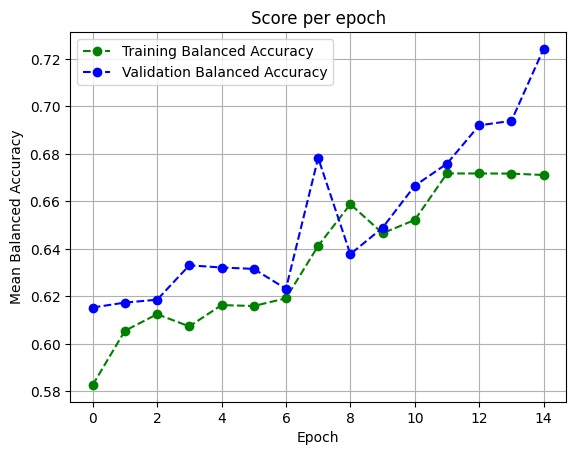

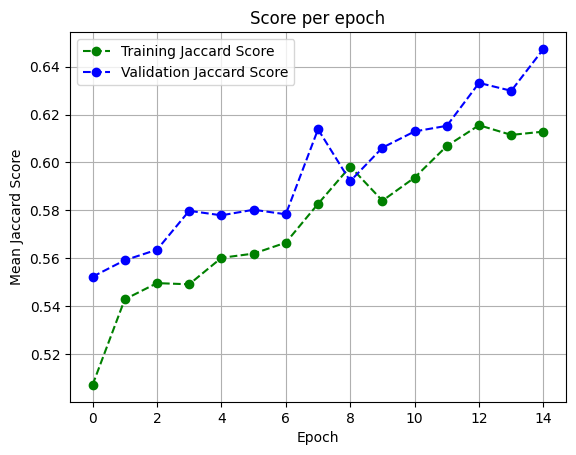

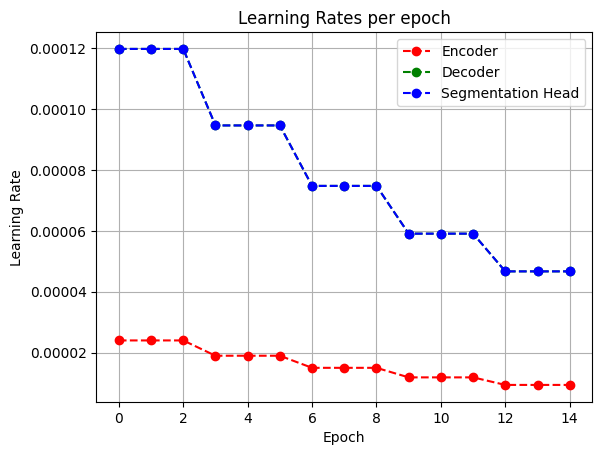

In [ ]:
plot_loss(history_load)
plot_score(history_load)
plot_lrs(history_load)

# Evaluation on Test Set of Baseline U-Net

In [ ]:
def evaluate(model):

    model.eval()
    model.to(device)
    confusion_matrix = np.zeros((3,3))
    test_metrics = [[],[],[]]

    with torch.no_grad():

        for i, data in enumerate(tqdm(test_loader)):

            image, mask = data
            image = image.to(device)
            mask = mask.to(device)

            #image = image.unsqueeze(0)
            #mask = mask.unsqueeze(0)

            #forward
            output = model(image)

            #evaluation metrics
            for imetr,metr in enumerate(metric_names):
                test_metrics[imetr].append(pixel_metrics(output,mask,metr))

            if (np.array(pixel_metrics(output,mask,"Confusion Matrix").shape != (3,3))):
                print(np.array(pixel_metrics(output,mask,"Confusion Matrix")))


            confusion_matrix += np.array(pixel_metrics(output,mask,"Confusion Matrix"))

            #output = output.cpu().squeeze(0)
    return test_metrics, confusion_matrix

In [ ]:
scores, conf_matrix = evaluate(unet_load)

  0%|          | 0/845 [00:00<?, ?it/s]

# 1. Confusion Matrix

Text(0.5, 23.52222222222222, 'Predicted Labels')

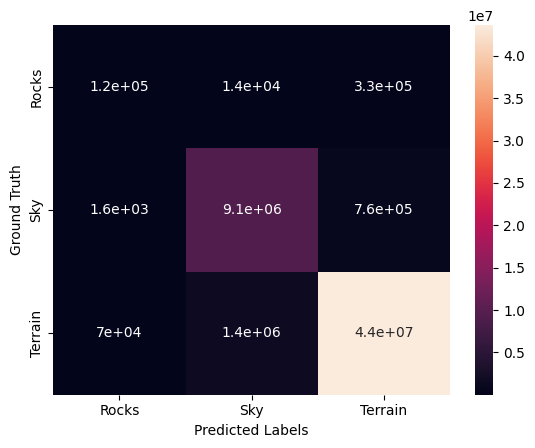

In [ ]:
import seaborn as sns

plt.figure()
sns.heatmap(pd.DataFrame(conf_matrix.tolist(),columns = ["Rocks","Sky","Terrain"],index = ["Rocks","Sky","Terrain"]), annot = True)
plt.ylabel("Ground Truth")
plt.xlabel("Predicted Labels")

# 2. Accuracy, Balanced Accuracy and Jaccard Score

In [ ]:
acc = scores[0]
bal_acc = scores[1]
jacc_score = scores[2]

print("Accuracy: {:.2f}".format(np.mean(acc)))
print("Balanced Accuracy: {:.2f}".format(np.mean(bal_acc)))
print("Jaccard Score: {:.2f}".format(np.mean(jacc_score)))

Accuracy: 0.95
Balanced Accuracy: 0.88
Jaccard Score: 0.79


In [ ]:
def predicted_mask(model,image):

    model.to(device)
    image = image.to(device)
    output = model(image)

    #applying softmax and choosing best class with argmax
    output = F.softmax(output, dim=1) #on all colors
    output = torch.argmax(output, dim=1) #on all colors

    return output

In [ ]:
ibest = bal_acc.index(max(bal_acc))
iworst = bal_acc.index(min(bal_acc))
irandom = random.randint(0,len(test_loader)-1)
#irandom = 737
irandom = 544

image_best = test_set[ibest][0]
image_worst = test_set[iworst][0]
image_rndm = test_set[irandom][0]

mask_best = test_set[ibest][1]
mask_worst = test_set[iworst][1]
mask_rndm = test_set[irandom][1]

predicted_best = predicted_mask(unet_load,image_best.view(1,1,npix_x,npix_y))
predicted_worst = predicted_mask(unet_load,image_worst.view(1,1,npix_x,npix_y))
predicted_random = predicted_mask(unet_load,image_rndm.view(1,1,npix_x,npix_y))

while (np.count_nonzero(predicted_random.cpu() == 0) == 0):
    irandom = random.randint(0,len(test_loader)-1)
    image_rndm = test_set[irandom][0]
    mask_rndm = test_set[irandom][1]
    print(irandom)
    predicted_random = predicted_mask(unet_load,image_rndm.view(1,1,npix_x,npix_y))

Text(0.5, 1.0, 'Image with U-Net Prediction (Random)')

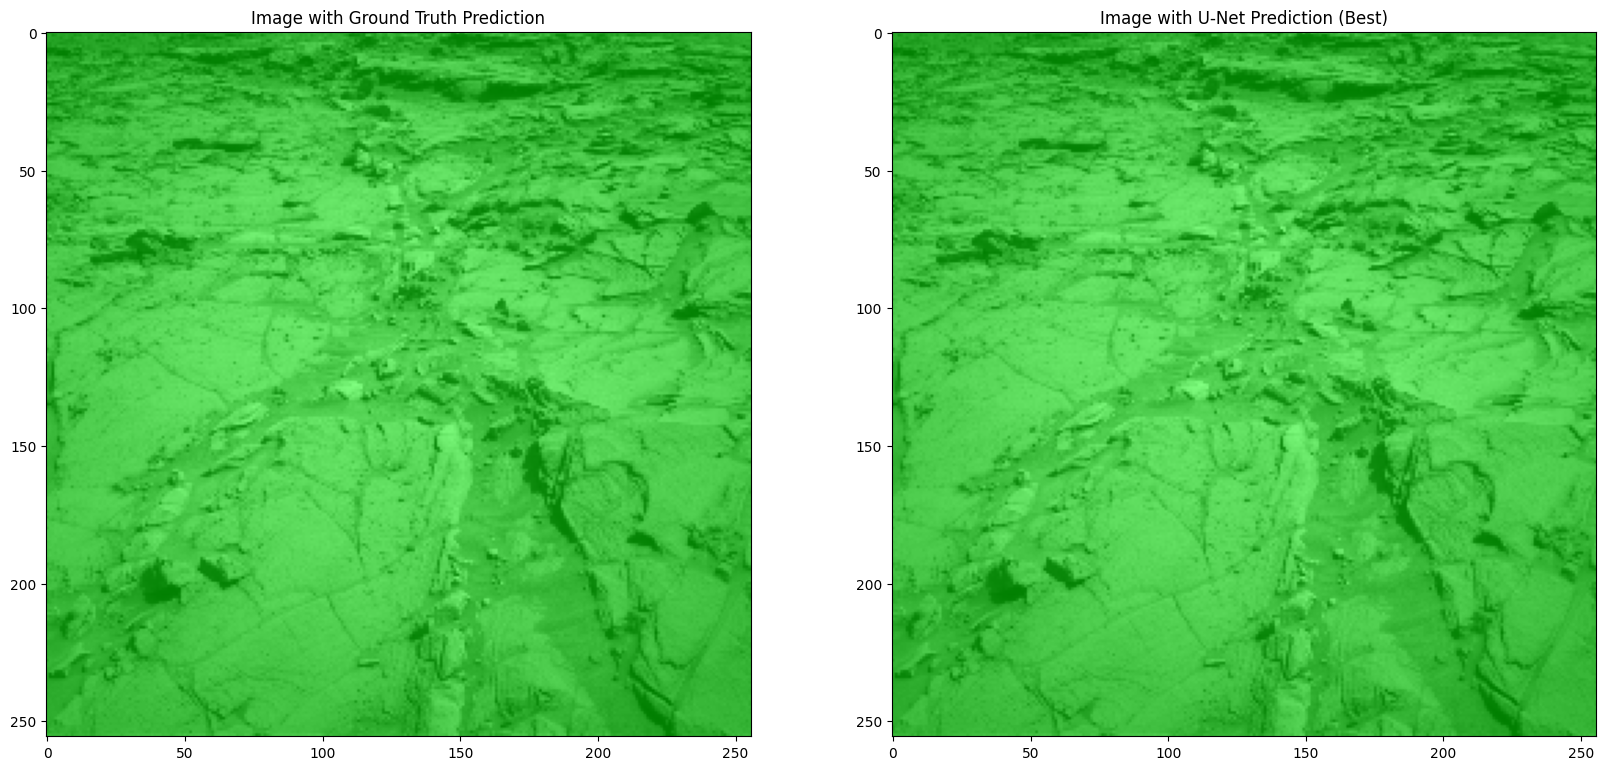

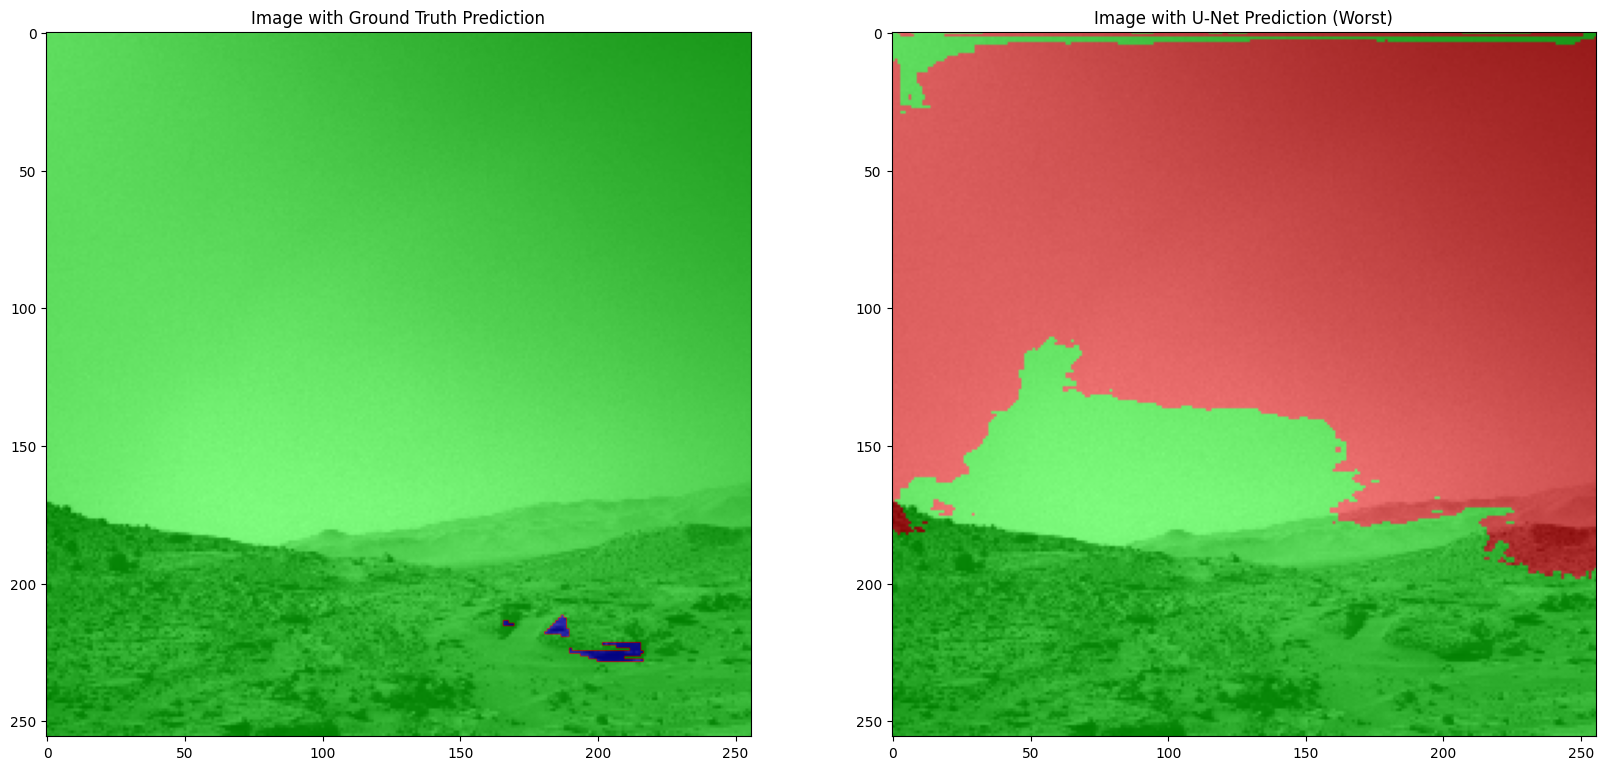

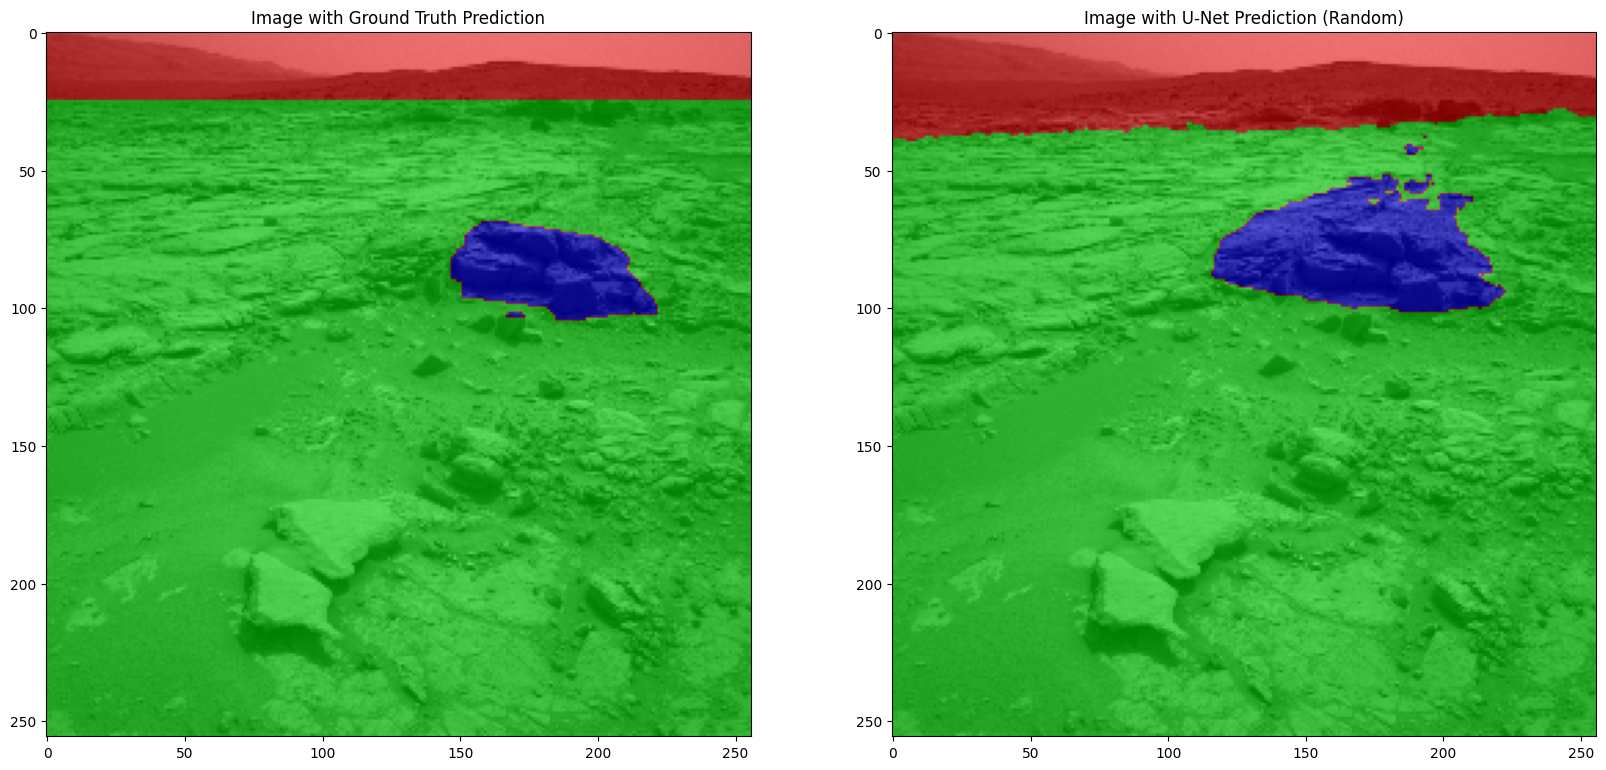

In [ ]:
#best prediction
fig, ax = plt.subplots(1,2, figsize=(20,10))

ax[0].imshow(image_best.permute(1, 2, 0), cmap = "gray")
ax[0].imshow(mask_best, alpha = 0.5, cmap = "brg", vmin = 0, vmax = 2)
ax[0].set_title('Image with Ground Truth Prediction')

ax[1].imshow(image_best.permute(1, 2, 0), cmap = "gray")
ax[1].imshow(predicted_best.cpu().view(npix_x,npix_y), alpha = 0.5, cmap = "brg",vmin = 0, vmax = 2)
ax[1].set_title('Image with U-Net Prediction (Best)')

#worst prediction
fig, ax = plt.subplots(1,2, figsize=(20,10))

ax[0].imshow(image_worst.permute(1, 2, 0), cmap = "gray")
ax[0].imshow(mask_worst, alpha = 0.5,cmap = "brg", vmin = 0, vmax = 2)
ax[0].set_title('Image with Ground Truth Prediction')

ax[1].imshow(image_worst.permute(1, 2, 0), cmap = "gray")
ax[1].imshow(predicted_worst.cpu().view(npix_x,npix_y), alpha = 0.5,cmap = "brg", vmin = 0, vmax = 2)
ax[1].set_title('Image with U-Net Prediction (Worst)')

#random prediction
fig, ax = plt.subplots(1,2, figsize=(20,10))

ax[0].imshow(image_rndm.permute(1, 2, 0),cmap="gray")
ax[0].imshow(mask_rndm, alpha = 0.5, cmap = "brg", vmin = 0, vmax = 2)
ax[0].set_title('Image with Ground Truth Prediction')

ax[1].imshow(image_rndm.permute(1, 2, 0),cmap="gray")
ax[1].imshow(predicted_random.cpu().view(npix_x,npix_y), alpha = 0.5, cmap = "brg", vmin = 0, vmax = 2)
ax[1].set_title('Image with U-Net Prediction (Random)')

# Comparison different models

In [ ]:
#functions to compare results
def plot_loss_compare(histories,labels,lasts = None):

    colors = ["r","g","b","c","m","y"]

    plt.figure()
    for ih,history in enumerate(histories):

        n_epochs_plot = len(history['val_loss'])
        start_epoch = 0
        if (lasts): start_epoch = n_epochs_plot - lasts
        plt.plot(history['val_loss'][start_epoch:n_epochs_plot],
                 label = labels[ih],
                 marker='o',
                 color = colors[ih],
                 linestyle = "dashed")

    plt.title('Validation Loss per epoch')
    plt.ylabel('Categorical Cross Entropy Loss');
    plt.xlabel('Epoch')
    plt.legend(loc = "best")
    plt.grid()
    plt.show()

def plot_score_compare(histories,labels,lasts = None):

    colors = ["r","g","b","c","m","y"]

    for imetr,metr in enumerate(metric_names):

        plt.figure()
        for ih,history in enumerate(histories):

            n_epochs_plot = len(history['val_metric'])
            start_epoch = 0
            if (lasts): start_epoch = n_epochs_plot - lasts
            val_score = [history['val_metric'][e][imetr] for e in range(start_epoch,n_epochs_plot)]
            plt.plot(val_score, label = labels[ih], marker='o', color = colors[ih],linestyle = "dashed")

        plt.title('Validation ' + metr + ' per epoch')
        plt.ylabel("Mean " + metr)
        plt.xlabel('Epoch')
        plt.legend(loc = "best")
        plt.grid()
        plt.show()


In [ ]:
unet_1,history_1 = torch.load('/kaggle/input/mars-models/Unet_baseline_rmab.pt')
unet_2,history_2 = torch.load('/kaggle/input/mars-models/Unet_adapt_rmab_parall.pt')
unet_3,history_3 = torch.load('/kaggle/input/mars-models/Unet_adapt_rmab_parall_offshelf.pt')
unet_4,history_4 = torch.load('/kaggle/input/mars-models/Unet_adapt_rmab_parall_offshelf_bnorm.pt')
unet_5,history_5 = torch.load('/kaggle/input/mars-models/Unet_adapt_rmab_series.pt')
unet_6,history_6 = torch.load('/kaggle/input/mars-models/Unet_adapt_rmab_series_offshelf.pt')

histories = [history_1,history_2,history_3,history_4,history_5,history_6]
models= [unet_1,unet_2,unet_3,unet_4,unet_5,unet_6]
names = ["Unet_baseline_rmab","Unet_adapt_parall_onshelf","Unet_adapt_parall_offshelf","Unet_adapt_parall_offshelf_bnorm","Unet_adapt_series_onshelf","Unet_adapt_series_offshelf"]

In [ ]:
print("Accuracy","Balanced Accuracy","IOU")
for ih,history in enumerate(histories):
    print("%.4f & %.4f & %.4f \\" % (history['val_metric'][-1][0],history['val_metric'][-1][1],history['val_metric'][-1][2]))

Accuracy Balanced Accuracy IOU
0.9327 & 0.6215 & 0.5548 \
0.8972 & 0.5499 & 0.4813 \
0.9427 & 0.6418 & 0.5888 \
0.9450 & 0.6499 & 0.5956 \
0.9231 & 0.6098 & 0.5339 \
0.9011 & 0.5816 & 0.5002 \


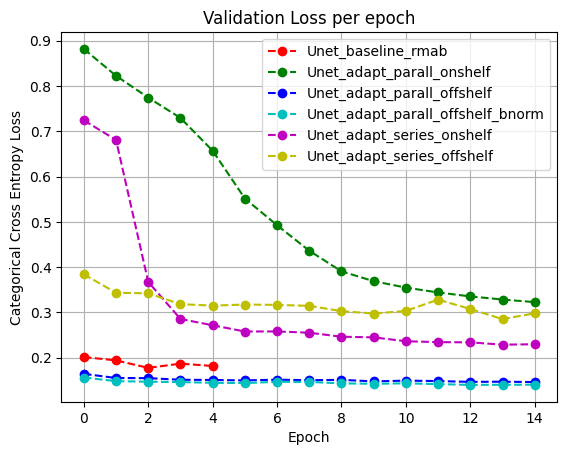

IndexError: list index out of range

<Figure size 640x480 with 0 Axes>

In [ ]:
plot_loss_compare(histories,names,15)
plot_score_compare(histories,names,15)

In [ ]:
unet_1,history_1 = torch.load('/kaggle/input/mars-models/Unet_baseline_rmab.pt')
unet_2,history_2 = torch.load('/kaggle/input/mars-models/Unet_finetuning_rmab_allfreezed_bntrain.pt')
unet_3,history_3 = torch.load('/kaggle/input/mars-models/Unet_finetuning_rmab_encfreezed_bnfreezed.pt')
unet_4,history_4 = torch.load('/kaggle/input/mars-models/Unet_finetuning_rmab_encfreezed_bntrain.pt')
unet_5,history_5 = torch.load('/kaggle/input/mars-models/Unet_finetuning_rmab_full.pt')

histories = [history_1,history_2,history_3,history_4,history_5]
models= [unet_1,unet_2,unet_3,unet_4,unet_5]
names = ["Unet_baseline_rmab","Unet_finetune_allfreezed_bntrain","Unet_finetune_encfreezed_bnfreezed","Unet_finetune_encfreezed_bntrain","Unet_finetune_full"]

In [ ]:
print("Accuracy","Balanced Accuracy","IOU")
for ih,history in enumerate(histories):
    print("%.4f & %.4f & %.4f \\" % (history['val_metric'][-1][0],history['val_metric'][-1][1],history['val_metric'][-1][2]))

Accuracy Balanced Accuracy IOU
0.9327 & 0.6215 & 0.5548 \
0.9096 & 0.5825 & 0.5076 \
0.9510 & 0.6462 & 0.5938 \
0.9355 & 0.6367 & 0.5651 \
0.9540 & 0.7242 & 0.6474 \


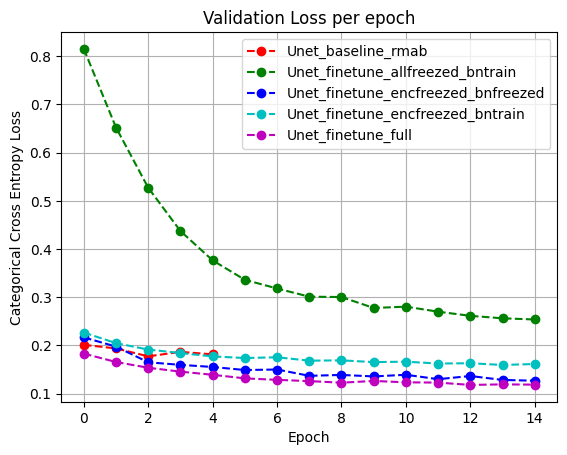

IndexError: list index out of range

<Figure size 640x480 with 0 Axes>

In [ ]:
plot_loss_compare(histories,names,15)
plot_score_compare(histories,names,15)

# MACs

In [ ]:
! pip install ptflops
from ptflops import get_model_complexity_info

with torch.cuda.device(0):

    #macs, params = get_model_complexity_info(unet, (1, npix_x, npix_y))
    #macs, params = get_model_complexity_info(unet, (1, npix_x, npix_y), ignore_modules = [torch.nn.BatchNorm2d])

    #macs, params = get_model_complexity_info(unet_smob_parall, (1, npix_x, npix_y))
    macs, params = get_model_complexity_info(unet_smob_series, (1, npix_x, npix_y))
    #macs, params = get_model_complexity_info(unet, (1, npix_x, npix_y), ignore_modules = [torch.nn.Conv2d,torch.nn.ReLU])

    print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
    print('{:<30}  {:<8}'.format('Number of parameters: ', params))

Unet_Adapters(
  15.72 M, 100.000% Params, 5.61 GMac, 99.819% MACs, 
  (encoder): ResNetEncoder_Adapter(
    12.57 M, 79.952% Params, 2.55 GMac, 45.347% MACs, 
    (conv1): Conv2d(3.14 k, 0.020% Params, 51.38 MMac, 0.914% MACs, 1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(128, 0.001% Params, 2.1 MMac, 0.037% MACs, 64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(0, 0.000% Params, 1.05 MMac, 0.019% MACs, inplace=True)
    (maxpool): MaxPool2d(0, 0.000% Params, 1.05 MMac, 0.019% MACs, kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      164.86 k, 1.049% Params, 675.81 MMac, 12.028% MACs, 
      (0): BasicBlock(
        82.43 k, 0.524% Params, 337.9 MMac, 6.014% MACs, 
        (conv1): conv_task(
          41.22 k, 0.262% Params, 168.82 MMac, 3.005% MACs, 
          (conv): Conv2d(36.86 k, 0.234% Params, 150.99 MMac, 2.687% MACs, 64, 64, kernel_size=(3, 3), strid